In [1]:
from io import BytesIO
import boto3
import multiprocessing as mp
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def load_data_from_s3(filename, format='csv'):
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket='loan-analysis-data', Key=filename)
    data = obj['Body'].read()
    f = BytesIO(data)
    if format=='csv':
        df = pd.read_csv(f, low_memory=False)
    if format=='pkl.bz2':
        df = pd.read_pickle(f, compression='bz2')
    return df    

In [69]:
# Read in loan ROIs
with open('data/loan_rois.pickle', 'rb') as handle:
    loan_rois = pickle.load(handle)

# Read in training data
training_loans = pd.read_pickle('data/cleaned_training_loans.pkl.bz2')
# Read in testing data
testing_loans = pd.read_pickle('data/cleaned_testing_loans.pkl.bz2')
training_loans.head()
testing_loans.head()
training_loans.index[:10]
training_loans['roi'].head()
roi_col = pd.DataFrame.from_dict(loan_rois, orient='index')
roi_col.info()
roi_col.head()
training_loans['roi'] = roi_col
training_loans['roi'].head(10)
training_loans.index = training_loans.index.astype(int)
training_loans.index
training_loans['roi'] = roi_col
training_loans['roi'].head(10)
training_loans.loc[10119623]['roi']
pd.read_pickle('data/cleaned_training_loans.pkl.bz2')
training_loans.to_pickle('data/cleaned_training_loans_indexed.pkl.bz2', compression='bz2')
testing_loans.set_index('id', inplace=True)
testing_loans.head(5)
testing_loans.to_pickle('data/cleaned_testing_loans.pkl.bz2', compression='bz2')
payments = load_data_from_s3('cleaned_payments_data.pkl.bz2', format='pkl.bz2')
payments.head()
test = payments.set_index(['RECEIVED_D', 'LOAN_ID'])
test.head()
from datetime import datetime
test.loc[datetime(2007,7,1)]
test[['RECEIVED_AMT_INVESTORS', 'PBAL_END_PERIOD_INVESTORS']].head()
test.to_pickle('data/cleaned_payments_data_indexed.pkl.bz2', compression='bz2')

In [2]:
training_loans = pd.read_pickle('data/cleaned_training_loans_after_recession.pkl.bz2')
testing_loans = pd.read_pickle('data/cleaned_testing_loans.pkl.bz2')

In [3]:
# Only include the loans beginning in 2010.
training_loans = training_loans[training_loans['issue_d'].isin(pd.date_range('2010-01-01', '2015-10-01')) == True]
#training_loans.to_pickle('data/cleaned_training_loans_after_recession.pkl.bz2', compression='bz2')

In [4]:
%run src/modeling.py
X_train, y_train = split_data_into_labels_and_target(training_loans)
X_test = testing_loans.drop(columns='issue_d')

In [6]:
from xgboost import XGBRegressor
model = XGBRegressor(n_jobs=-1)
fit_model = train_model(model, X_train, y_train)
#test_predictions = get_predictions(fit_model, X_test)

In [67]:
train_predictions = fit_model.predict(X_train)

In [68]:
test_predictions = fit_model.predict(X_test)
test_predictions

array([  6.8195233, -12.377034 ,   5.547388 , ...,   3.8532567,
         3.863252 ,   4.315468 ], dtype=float32)

In [69]:
copy_training = X_train.copy(deep=True)
copy_testing = X_test.copy(deep=True)

In [70]:
copy_training['predicted_roi'] = train_predictions
copy_testing['predicted_roi'] = test_predictions

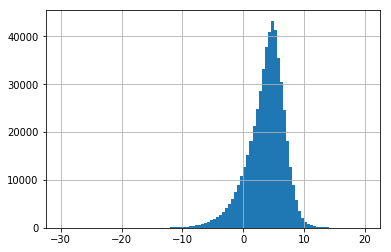

In [71]:
copy_training['predicted_roi'].hist(bins=100)

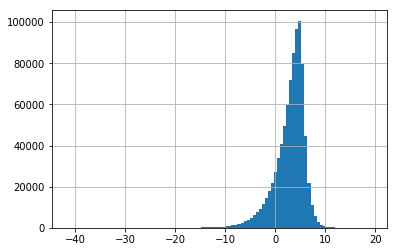

In [72]:
copy_testing['predicted_roi'].hist(bins=100)

In [73]:
simulation_df = create_dataframe_for_simulation(testing_loans, test_predictions)
simulation_df.groupby(['issue_d'], as_index=False).agg(['mean'])

,loan_amnt,predicted_roi
,mean,mean
issue_d,,
2015-10-01,12813.611328,2.490578
2015-11-01,12709.166016,2.494461
2015-12-01,12602.059570,2.336034
2016-01-01,13834.327148,2.538456
2016-02-01,13623.710938,2.848032
2016-03-01,13194.706055,2.259217
2016-04-01,12977.230469,2.836740
2016-05-01,12873.698242,2.688637


In [76]:
simulation_df.head()

,issue_d,loan_amnt,predicted_roi
id,,,
68407277,2015-12-01,3600.0,6.819523
68495092,2015-12-01,8650.0,-12.377034
68466961,2015-12-01,28000.0,5.547388
68466916,2015-12-01,25000.0,4.509906
68354783,2015-12-01,9600.0,4.441494


In [77]:
simulation_df = simulation_df.reset_index(level=0).set_index('issue_d')
simulation_df.head()

,id,loan_amnt,predicted_roi
issue_d,,,
2015-12-01,68407277,3600.0,6.819523
2015-12-01,68495092,8650.0,-12.377034
2015-12-01,68466961,28000.0,5.547388
2015-12-01,68466916,25000.0,4.509906
2015-12-01,68354783,9600.0,4.441494


In [85]:
simulation_df.to_pickle('data/test_predictions_xgb_standard.pkl.bz2', compression='bz2')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
fit_model = train_model(model, X_train, y_train)

In [ ]:
rf_predictions = get_predictions(fit_model, X_test)

In [ ]:
simulation_df = create_dataframe_for_simulation(testing_loans, rf_predictions)
simulation_df = simulation_df.reset_index(level=0).set_index('issue_d')
simulation_df.head()

In [ ]:
simulation_df.to_pickle('data/test_predictions_rf_1000_trees.pkl.bz2', compression='bz2')

In [116]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
fit_model = train_model(model, X_train, y_train)

In [117]:
dt_predictions = get_predictions(fit_model, X_test)
simulation_df = create_dataframe_for_simulation(testing_loans, dt_predictions)
simulation_df = simulation_df.reset_index(level=0).set_index('issue_d')
simulation_df.head()

,id,loan_amnt,predicted_roi
issue_d,,,
2015-12-01,68407277,3600.0,15.025635
2015-12-01,68495092,8650.0,-86.340256
2015-12-01,68466961,28000.0,6.723257
2015-12-01,68466916,25000.0,8.178842
2015-12-01,68354783,9600.0,7.561728


In [118]:
simulation_df.to_pickle('data/test_predictions_dt.pkl.bz2', compression='bz2')

In [10]:
testing_loans.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,fico_range_high,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
id,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,13.990000,123.029999,10.0,55000.0,2015-12-01,5.910000,0,675.0,679.0,...,0,0,0,0,0,0,0,0,0,0
68495092,8650.0,19.889999,320.989990,8.0,55000.0,2015-12-01,25.490000,0,675.0,679.0,...,0,0,0,0,0,0,0,0,0,0
68466961,28000.0,6.490000,858.049988,10.0,92000.0,2015-12-01,21.600000,0,720.0,724.0,...,0,0,0,0,0,0,0,0,0,0
68466916,25000.0,7.490000,777.549988,10.0,109000.0,2015-12-01,26.020000,0,745.0,749.0,...,0,0,0,0,0,0,0,0,0,0
68354783,9600.0,7.490000,298.579987,8.0,60000.0,2015-12-01,22.440001,0,695.0,699.0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
predictions = testing_loans.int_rate

In [14]:
simulation_df = create_dataframe_for_simulation(testing_loans, predictions)
simulation_df = simulation_df.reset_index(level=0).set_index('issue_d')
simulation_df.head()

,id,loan_amnt,predicted_roi
issue_d,,,
2015-12-01,68407277,3600.0,13.990000
2015-12-01,68495092,8650.0,19.889999
2015-12-01,68466961,28000.0,6.490000
2015-12-01,68466916,25000.0,7.490000
2015-12-01,68354783,9600.0,7.490000


In [15]:
simulation_df.to_pickle('data/naive_predictions.pkl.bz2', compression='bz2')